```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Day in Riverbend Example

An illustrative social simulation with 5 players which simulates a normal day in an imaginary town caller Riverbend. Each player has their own configurable backstory. The agents are configured to re-implement the architecure in Park et al. (2023) - they have reflection, plan, and identity components; their associative memory uses importance function. This is _not_ an exact re-implementation.

Park, J.S., O'Brien, J.C., Cai, C.J., Morris, M.R., Liang, P. and Bernstein, M.S., 2023. Generative agents: Interactive simulacra of human behavior. arXiv preprint arXiv:2304.03442.

## Init and import

In [1]:
!pip install git+https://github.com/google-deepmind/concordia.git

  Running command git clone --filter=blob:none --quiet https://github.com/google-deepmind/concordia.git 'C:\Users\sirius\AppData\Local\Temp\pip-req-build-iucc95tk'



  Cloning https://github.com/google-deepmind/concordia.git to c:\users\sirius\appdata\local\temp\pip-req-build-iucc95tk
  Resolved https://github.com/google-deepmind/concordia.git to commit 996b6d14e4ba6265363070c65958a4998d282693
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached google_cloud_aiplatform-1.48.0-py2.py3-none-any.whl.metadata (30 kB)
  Using cached langchain-0.1.16-py3-none-any.whl.metadata (13 kB)
  Using cached pandas-2.0.3-cp311-cp311-win_amd64.whl.metadata (18 kB)
  Using cached reactivex-4.0.4-py3-none-any.whl.metadata (5.5 kB)
  Using cached retry-0.9.2-py2.py3-none-any.w

In [4]:
!pip install sentence_transformers

     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ---------- -------------------------- 41.0/138.0 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 138.0/138.0 kB 1.6 MB/s eta 0:00:00
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/171.5 kB ? eta -:--:--
   --------------------------------------- 171.5/171.5 kB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/388.9 kB ? eta -:--:--
   ---------------------------------------- 388.9/388.9 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.9/159.8 MB 30.1 MB/s eta 0:00:06
    --------------------------------------- 3.0/159.8 MB 38.9 MB/s eta 0:00:05
    --------------------------------------- 3.5/159.8 MB 27.5 MB/s eta 0:00:06
    --------------------------------------- 3.9/159.8 MB 25.1 MB/s eta 0:00:07
   - ----------

In [5]:
# @title Imports

import collections
import concurrent.futures
import datetime
import random

# from google.colab import widgets  # pytype: disable=import-error
from IPython import display
import sentence_transformers

from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia.agents import basic_agent
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import measurements as measurements_lib
from concordia.language_model import gpt_model
from concordia.language_model import gcloud_model
from concordia.utils import html as html_lib
from concordia.utils import plotting


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# @title Setup sentence encoder
st_model = sentence_transformers.SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embedder = lambda x: st_model.encode(x, show_progress_bar=False)


c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sirius\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Note: there must be ".env " file in this folder with GPT_API_KEY key string

In [28]:
import os


from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  # read local .env file

GPT_API_KEY=os.environ.get("GPT_API_KEY")

GPT_MODEL_NAME= 'gpt-3.5-turbo-16k'
#
#


In [29]:
GPT_MODEL_NAME

'gpt-3.5-turbo-16k'

In [30]:
# @title Language Model - pick your model and provide keys
CLOUD_PROJECT_ID = '' #@param {type: 'string'}
# GPT_API_KEY = '' #@param {type: 'string'}
# GPT_MODEL_NAME = '' #@param {type: 'string'}

USE_CLOUD = False #@param {type: 'boolean'}

if USE_CLOUD:
  model = gcloud_model.CloudLanguageModel(project_id= CLOUD_PROJECT_ID)
else:
  model = gpt_model.GptLanguageModel(api_key=GPT_API_KEY, model_name=GPT_MODEL_NAME)

## Configuring the generic knowledge of players and GM.

In [31]:
#@title Make importance models

importance_model = importance_function.AgentImportanceModel(model)
importance_model_gm = importance_function.ConstantImportanceModel()


In [32]:
#@title Make the clock
SETUP_TIME = datetime.datetime(hour=8, year=2024, month=9, day=1)

START_TIME = datetime.datetime(hour=9, year=2024, month=10, day=1)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[datetime.timedelta(hours=1), datetime.timedelta(seconds=10)])


In [33]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'There is a hamlet named Riverbend.',
    'Riverbend is an idyllic rural town.',
    'The river Solripple runs through the village of Riverbend.',
    'The Solripple is a mighty river.',
    'Riverbend has a temperate climate.',
    'Riverbend has a main street.',
    'There is a guitar store on Main street Riverbend.',
    'There is a grocery store on Main street Riverbend.',
    'There is a school on Main street Riverbend.',
    'There is a library on Main street Riverbend.',
    'Riverbend has only one pub.',
    'There is a pub on Main street Riverbend called The Sundrop Saloon.',
    'Town hall meetings often take place at The Sundrop Saloon.',
    'Riverbend has a small green park',
    'The main crop grown on the farms near Riverbend is corn.',
    'Farms near Riverbend depend on water from the Solripple river.',
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


Riverbend is a picturesque rural town with a powerful river running through it. It has a temperate climate and a main street with various establishments including a guitar store, grocery store, school, library, and a pub called The Sundrop Saloon. The town also has a small green park and farms that rely on water from the Solripple river to grow corn. Town hall meetings often take place at The Sundrop Saloon.


## Functions to build the players

In [34]:
# @title setup formative memory factories
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)
formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [35]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):
  mem = formative_memory_factory.make_memories(agent_config)

  # Build the player.

  time = components.report_function.ReportFunction(
      name='current_time', function=clock.current_time_interval_str
  )

  identity = components.identity.SimIdentity(model, mem, agent_config.name)
  goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal
  )
  reflection = components.reflection.Reflection(
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      importance_threshold=15.0,
      verbose=False,
  )
  plan = components.plan.SimPlan(
      model,
      mem,
      agent_config.name,
      clock_now=clock.now,
      components=[identity, time],
      goal=goal_component,
      verbose=False,
  )
  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )
  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      components=[identity],
      component_name='summary of observations',
  )


  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )

  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=True,
      components=[
          identity,
          plan,
          reflection,
          time,
          summary_obs,
          current_obs,
          goal_metric,
          morality_metric,
      ],
  )

  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )

  agent.add_component(reputation_metric)

  return agent

## Configure and build the players

In [36]:
NUM_PLAYERS = 5

def make_random_big_five()->str:
  return str({
      'extraversion': random.randint(1, 10),
      'neuroticism': random.randint(1, 10),
      'openness': random.randint(1, 10),
      'conscientiousness': random.randint(1, 10),
      'agreeableness': random.randint(1, 10),
  })

scenario_premise = [

    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Organise a street party in Riverbend.',
        context=shared_context+'Alice is very socially active and knows everyone in town',
        traits = make_random_big_five()
            ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Start a chess club in Riverbend.',
        context=shared_context + 'Bob is a chess enthusiast',
        traits = make_random_big_five()
            ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Organise an ale festival at the Sundrop Saloon.',
        context=shared_context + 'Charlie works at the Sundrop Saloon and loves real ales',
        traits = make_random_big_five()
            ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal=(
            'Take students on a tour of Riverbend'
            ' it is funny.'
        ),
        context=shared_context + 'Dorothy is a teacher at school in Riverbend',
        traits = make_random_big_five()
            ),
    formative_memories.AgentConfig(
        name='Ellen',
        gender='female',
        goal=(
            'Write a paper on the history of Riverbend.'
        ),
        context=shared_context + 'Ellen is a librarian in the library in Riverbend',
        traits = make_random_big_five()
    ),
]

In [37]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)


Number of generated formative episodes (1) does not match number of formative ages (5).
Number of generated formative episodes (1) does not match number of formative ages (5).
Number of generated formative episodes (1) does not match number of formative ages (5).
Number of generated formative episodes (1) does not match number of formative ages (5).
Number of generated formative episodes (1) does not match number of formative ages (5).


## Build GM

In [38]:
game_master_memory = associative_memory.AssociativeMemory(
    embedder, importance_model_gm.importance, clock=clock.now)

In [39]:
# @title Create components and externalities
citizen_names = [player.name for player in players]
player_names = [player.name for player in players]

facts_on_village = generic_components.constant.ConstantComponent(
    ' '.join(shared_memories), 'General knowledge of Riverbend'
)
player_status = gm_components.player_status.PlayerStatus(
    clock.now, model, game_master_memory, player_names
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory
)
time_display = gm_components.time_display.TimeDisplay(clock)


convo_externality = gm_components.conversation.Conversation(
    players,
    model,
    clock=clock,
    memory=game_master_memory,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=2,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status],
)

In [40]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        facts_on_village,
        player_status,
        convo_externality,
        direct_effect_externality,
        relevant_events,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [41]:
clock.set(START_TIME)

In [42]:
#@title Initial observations and player location
for player in players:
  player.observe(
      f'{player.name} is at home, they have just woken up.'
  )
  game_master_memory.add(f'{player.name} is at their private home.')


In [44]:
# @title Expect about 2-3 minutes per step.
episode_length = 12  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


KeyboardInterrupt: 

## Summary and analysis of the episode

In [45]:
# @title Metrics plotting



group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

tb = widgets.TabBar([channel for channel in measurements.available_channels()])
for channel in measurements.available_channels():
  with tb.output_to(channel):
    plotting.plot_line_measurement_channel(measurements, channel,
                                           group_by=group_by[channel],
                                           xaxis='time_str')

NameError: name 'widgets' is not defined

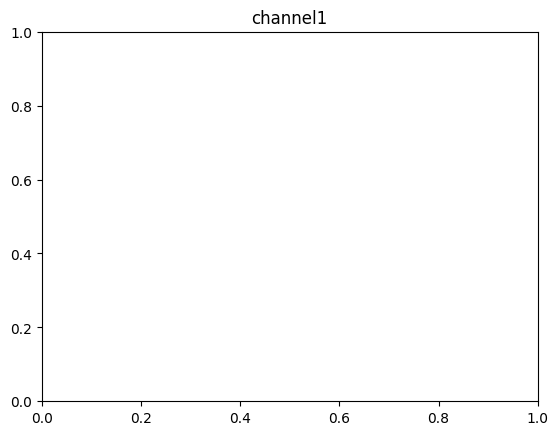

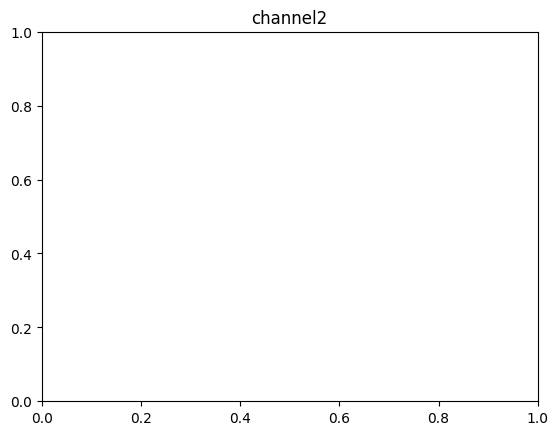

In [46]:
import collections
import matplotlib.pyplot as plt

# Assuming you have a plotting function similar to plot_line_measurement_channel
def plot_line_measurement_channel(measurements, channel, group_by, xaxis):
    # Your plotting code here
    pass

# Mockup of measurements and plotting module
measurements = {'available_channels': lambda: ['channel1', 'channel2']} 
plotting = {'plot_line_measurement_channel': plot_line_measurement_channel}

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

# Using Matplotlib for plotting
for channel in measurements['available_channels']():
    plt.figure()
    plot_line_measurement_channel(measurements, channel, group_by=group_by[channel], xaxis='time_str')
    plt.title(channel)
    plt.show()


In [47]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=3500, max_tokens=3500, terminators=())
print(episode_summary)

len(detailed_story):  19787
In a peaceful town called Riverbend, a series of events unfolded on October 1, 2024. The day began with Alice preparing and enjoying breakfast at her private home, followed by Charlie, Dorothy, and Ellen also being at their respective homes. Bob joined in by preparing and eating breakfast at his private home as well. Meanwhile, Charlie went for a morning jog, and Ellen had breakfast and read the newspaper at her private home.

As the morning progressed, Alice left her home for a jog in the nearby park, passing by Bob's house. Ellen also went for a jog, crossing paths with Charlie and engaging in a brief chat about their exercise routines. Dorothy joined in the jogging activities, while Charlie continued working on a project at home.

Throughout the day, Alice continued her workout at the park, while Bob cleaned his house and went grocery shopping. Ellen organized a community book drive, and Charlie took breaks from their project to go for walks in the park. 

In [48]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000, add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=3500, max_tokens=3500, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [49]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [html_lib.PythonObjectToHTMLConverter(history.get_history()).convert() for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [63]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Day in Riverband experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [64]:
file_path = 'day_in_riverbend_output.html'

# Write HTML to the file
with open(file_path, 'w') as html_file:
    html_file.write(tabbed_html)

print(f"HTML saved to {file_path}")

HTML saved to day_in_riverbend_output.html


In [65]:
display.HTML(tabbed_html)

#Interact with a specific player

In [78]:
sim_to_interact = 'Dorothy'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [79]:
utterence_from_user = [
'What do you think of Charlie?',
'How was your day?',
'If we measure your happiness from 0 to 100, what was it value in the morning? Answer value as number.',
'If we measure your happiness from 0 to 100, what was it value in the evening? Answer value as number.',
'What should be improved in Riverband?'
]

for utterence in utterence_from_user:
    interrogation += f'{user_identity}: {utterence}'
    player_says = selected_player.say(interrogation)
    interrogation += f'\n{sim_to_interact}: {player_says}\n'

Ellen



Dorothy context of action:
Dorothy's reflection:
1. Dorothy is a dedicated and passionate individual, as evidenced by their involvement in environmental conservation, community service, and personal growth activities.
2. Dorothy values new experiences and is open to exploring different cultures and perspectives, as seen through their solo backpacking trip and their love for their hometown.
3. Dorothy is determined and willing to step out of their comfort zone in order to achieve personal growth and overcome challenges, as demonstrated by their participation in a school debate competition.
4. Dorothy has a natural ability to connect with others and make a positive impact on their community, as shown through their successful charity bake sale and organization of a town-wide clean-up day.
5. Dorothy has a strong passion for history, adventure, and the unknown, which was sparked at a young age and continues to drive their curiosity and desire for exploration.

Dorothy's current_time:
 01 

NameError: name 'Ellen' is not defined